In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
from sklearn import metrics

In [3]:
from IPython.display import HTML
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [4]:
calories = pd.read_csv("calories.csv")
exercise = pd.read_csv("exercise.csv")

## General Overview of Dataset

In [ ]:
calories.head()

In [ ]:
exercise.head()

In [ ]:
exercise_df = exercise.merge(calories , on = "User_ID")
exercise_df.head()

In [ ]:
print("This dataset has " , exercise_df.shape[0] ," instances and ",  exercise_df.shape[1] , " columns.")

In [ ]:
print("Columns : ")
for i , column in zip(range(len(exercise_df.columns)) , exercise_df.columns):
  print("\t" , i + 1 , "." ,  column)

1.**User_ID** : The ID of the person which is unique.\
2.**Gender** : Gender of the person.\
3.**Age** : Age of the person.\
4.**Height** : Height of the person in $cm$.\
5.**Weight** : Weight of the person in $kg$.\
6.**Duration** : Duration of the person's exercise/activity.\
7.**Heart_Rate** : Heart rate per $min$ of the person.\
8.**Body_Temp** : Body temperature of the person in $C^{\circ}$.\
9.**Calories** : Calories burned in kilo calories.

### Dataset's Overall Statistic

In [ ]:
exercise_df.describe()

* As we can see, the table above shows the `Descriptive Statistics`(for example `centeral tendency`) of each column or feature.

* For example for `Age` column.%25 of the data lie between **20** and **28**, anohter %25 lie between **28** and **39**, and so on.The box plot shows the exact concept that I just mentioned.

* The outliers are shown with dots in box plots, which we will discuss about them in the next section.

In [ ]:
c = ['b' , 'g' , 'r' , 'c' , 'm' , 'y' , 'k' , 'w' , 'b']
fig1 , axes = plt.subplots(len(exercise_df.columns) , 1 , figsize = (10 , 20))
plt.subplots_adjust(wspace = 0.3 , hspace = 0.7)
axes = axes.flatten()             #for using axes indeces with one dimention array instead of two dimension
for i , column in zip(range(len(exercise_df.columns)) , exercise_df.columns):
  try:
    sns.boxplot(data = exercise_df , x = column , color = c[i] , ax = axes[i])
  except:
    fig1.delaxes(axes[i])
    continue

### Overall information of dataset

In [ ]:
exercise_df.info()

### Null Values
In this section we are going to check whether this dataset has null values or not.We will check this with heatmap.Because it is easy to understand and we can see dataset's condition at a glance. 

In [ ]:
sns.heatmap(exercise_df.isnull() , yticklabels = False , cbar = False , cmap = "viridis")

* As we can see, fortunately, this dataset does not have any null/NaN values, which is good and it is not necessary to do extra manipulations(for instance imputation , dropping or filling NaN values etc.) with this dataset.

### Drop Duplicates
Lets assure that this dataset does not contain any duplicate values in `User_ID` column.

In [ ]:
print("The shape of dataset before dropping duplicates : " , exercise_df.shape)
exercise_df.drop_duplicates(subset = ['User_ID'], keep='last' , inplace = True)    # Keeping the first example of duplicates in 'User_ID' column.
print("The shape of dataset after dropping duplicates : " , exercise_df.shape)

* As we can see the shape of dataset before and after dropping duplicates is the same.It is a good sign, because we do not need to be worry about `Data Leakage`.

* In the next step we have to delete `User_ID` feature.Because it is a `low predictive feature`.In other words, it is not only a useless feature for our calorie burned prediction model but also has a negative impact on model's accuracy.

In [15]:
exercise_df.drop(columns = "User_ID" , inplace = True)

* For avoiding any `Data Leakage` in our model, let's split our data into training set and test set before doing any `feature engineering`.

In [ ]:
exercise_train_data , exercise_test_data = train_test_split(exercise_df , test_size = 0.2 , random_state = 1)
print("Shape of training data : " , exercise_train_data.shape)
print("Shape of test data : " , exercise_test_data.shape)

### Dataset's Distribution

One of the main criterions that whether we will be able to deploy our model into production or not, is that **the distribution of features for both training set and test set must be similar**.This is because the model is fitting on the training set and the model keeps in mind the training set patterns.When the distribution of test set is different from the training set it means that the model can not predict very well on test set examples and unlike the training set accuracy, the testing set accuracy will be low.This is because, at first, we have to see and compare the distributions for both test set and training set and check whether both have the same distribution or not.

In [17]:
from matplotlib import style
style.use("bmh")

In [ ]:
c = ['b' , 'g' , 'r' , 'c' , 'm' , 'y' , 'k' , 'w' , 'b']
fig1 , axes = plt.subplots(len(exercise_train_data.columns) , 2 , figsize = (10 , 20))
plt.subplots_adjust(wspace = 0.3 , hspace = 0.7)
axes = axes.flatten()             #for using axes indeces with one dimention array instead of two dimension

for i , column , color in zip(range(0 , len(exercise_train_data.columns) * 2 , 2) , exercise_train_data.columns , c):
  try:
    axes[i].title.set_text(column + " Train Distribution")
    sns.kdeplot(data = exercise_train_data , x = column , ax = axes[i] , color = color)
  except:
    fig1.delaxes(axes[i])
    continue

for i , column , color in zip(range(1 , len(exercise_train_data.columns) * 2 , 2) , exercise_train_data.columns , c):
  try:
    axes[i].title.set_text(column + " Test Distribution")
    sns.kdeplot(data = exercise_test_data , x = column , ax = axes[i] , color = color)
  except:
    fig1.delaxes(axes[i])
    continue

In [ ]:
sns.pairplot(exercise_train_data[["Weight" , "Height" , "Duration" , "Heart_Rate" , "Calories" , "Gender"]] , hue = "Gender")

* As we can see from graphs above, there is not a specific correlation or relationship between most of the features in the dataset.For example,there is not a specific relationship between `Duration` and `Weight` or between `Duration` and `Hight`.This is because exercisers may have different exercise duration no matter of their `Weight` and `Height`.

* In some cases, a featrue has a low relationship with another feature, like `Duration` and `Heart_Rate`.Somehow(with low confident) we can say that the more time somebody exercises the more 'Heart Rate' per minute he/she will have.

* In some cases , two featrues have a high relationship(in compare to last two cases), like `Height` and `Weight`.
---
* There are more informations and benefits that we can get from `Correlation` concept.But thats for now and we will go further in the next section.

### Exploratory Data Analysis(EDA)

In [ ]:
print('Minimum age in dataset is : ' , exercise_train_data["Age"].min())
print('Maximum age in dataset is : ' , exercise_train_data["Age"].max())

* As we can see the oldest person in dataset is 79 years old and the youngest is 20 years old.What we want to do is divide this range of ages into several named ranges.In other words we want to convert the continuous column into categorical column.\
The ranges are:

| Name            | Age           |
| ----------------|:-------------:|
| **Young**       |[20 , 40)      |
| **Middle-Aged** |[40 , 60)      |
| **Old**         |[60 , 80)      |
 


In [ ]:
age_groups = ["Young" , "Middle-Aged" , "Old"]
exercise_train_data["age_groups"] = pd.cut(exercise_train_data["Age"] , bins = [20 , 40 ,60 , 80] , right = False , labels = age_groups)
exercise_train_data["age_groups"].head()

In [ ]:
exercise_train_data["age_groups"].value_counts()

* As we can see we have just converted a continuous column into a categorical column.Now its time to analyze `age_groups` column in terms of different aspects.

In [ ]:
plt.rcParams["figure.figsize"] = 8 , 6
sns.countplot(data = exercise_train_data , x = "age_groups")

* As we expected, there is a significant difference between in counts of different age groups.Most of the people of this dataset are **young**.The second is **middle-aged** and the third one is **old**.

Lets analyze how many kilocalories each age groups burned.We will do this with `box plot`.Because `box plot` has a intuitive graph that we can extract **Median** , **Interquartile Range** , **Outliers** and etc.Just like the picture below shows.

![alt text](https://miro.medium.com/max/18000/1*2c21SkzJMf3frPXPAR_gZA.png "Box plot structure")


In [ ]:
fig = px.box(exercise_train_data , x= "age_groups" , y = "Calories" , color = "Gender")

fig.update_layout(      
    width=700,
    height=450,
)

fig.show()

* As we can observe, old individuals have burned more kilocalories in compare of two other age groups.And the young persons are the least in burning kilocalories which is a surprise!

* Another interesting thing is, females in all age ranges performed very similar.In other words, they burned same amount of kilocalories in average.But for males, old group outperformed and the youth have the weakest performance.

* Also there is an outlier for young group which is shown by a point.This point has a value which is greater than third quartile value(Q3) plus 1.5 times of interquartile range magnitude.
\
\
`Outlier` > `Q3 + 1.5 * IQR`\
OR\
`Outlier` < `Q1 - 1.5 * IQR`


Now lets see which group have the most exercise duration in minutes.

In [ ]:
fig = px.box(exercise_train_data , x= "age_groups" , y = "Duration" , color = "Gender")

fig.update_layout(      
    width=750,
    height=450,
)

fig.show()

* As we can see , the exercise duration of each group is pretty identical.Every group have the same interquartile range , median and so on.

* In addition, the duration is very similar for males and females in `old` and `middle-aged` groups.But in `youth`, males outperformed.

* Another tip is, the median exercise duration of this dataset is about 15 minutes.We will assure this by the code bellow:

### Gender
Lets plot the count plot of each gender to see how many exercisers are male and how many of them are female.

In [ ]:
plt.rcParams["figure.figsize"] = 8 , 6
sns.countplot(data = exercise_train_data , x = "Gender")

* As we can see, number of females are slightly higher than man but this distinction is not significant.we can say, in general, they are equal.


\
In this section, lets compare the exercise duration between males and females. 

In [ ]:
fig = px.box(exercise_train_data , x= "Gender" , y = "Duration")

fig.update_layout(      
    width=700,
    height=450,
)

fig.show()

* As we can observe the median , IQR and etc. for both groups are overly identical.We proved this fact in the previous section. 

In [ ]:
fig = px.box(exercise_train_data , x= "Gender" , y = "Heart_Rate")

fig.update_layout(      
    width=700,
    height=450,
)

fig.show()

* As we can see, again the overall heart rate of both male and female are similar.In addition to this, we have an outliers for the male.


In this section our purpose is combine the `Weight` column and the `Height` column values to perform a simple BMI calculation to classify individuals of this dataset into different groups according to their BMI value.

* The BMI(Body Mass Index) formula:


$BMI = \frac{Weight(kg)}{Height(m)^2}$

OR

$BMI = \frac{Weight(Ib)}{Height(in)^2}$


* The first formula will be used because the units for `Weight` and `Height` of this dataset is `kg` and `meter` in respect.

* According to [this page](https://en.wikipedia.org/wiki/Body_mass_index) we will classify instances according to below table:


|   Categoty                                       | from          | to    |
| -------------------------------------------------|:-------------:| -----:|
| Very severely underweight                        | --            |  15   |
| Severely underweight                             | 15            |  16   |
| Underweight                                      | 16            |  18.5 |
| Normal (healthy weight)                          | 18.5          |  25   |
| Overweight                                       | 25            |  30   |
| Obese Class I (Moderately obese)                 | 30            |  35   |
| Obese Class II (Severely obese)                  | 35            |  40   |
| Obese Class III (Very severely obese)            | 40            |       |

* We will classify examples according to above category:

In [29]:
for data in [exercise_train_data , exercise_test_data]:         # adding BMI column to both training and test sets
  data["BMI"] = data["Weight"] / ((data["Height"] / 100) ** 2)
  data["BMI"] = round(data["BMI"] , 2)

In [30]:
# exercise_test_data["BMI"] = exercise_test_data["Weight"] / ((exercise_test_data["Height"] / 100) ** 2)
# exercise_test_data["BMI"] = round(exercise_test_data["BMI"] , 2)
# exercise_test_data.head()

In [ ]:
bmi_category = ["Very severely underweight" , "Severely underweight" ,
                "Underweight" , "Normal" ,
                "Overweight" , "Obese Class I" ,
                "Obese Class II" , "Obese Class III"]

exercise_train_data["Categorized_BMI"] = pd.cut(exercise_train_data["BMI"] , bins = [0 , 15 , 16 , 18.5 , 25 , 30 , 35 , 40 , 50]
                                              , right = False , labels = bmi_category)

exercise_train_data["Categorized_BMI"] = exercise_train_data["Categorized_BMI"].astype("object") # converting 'categorical' dtype intp 'object' dtype for "Categorized_BMI" column
exercise_train_data.head()

Now lets see the `Categorized_BMI` distribution in this dataset.

In [ ]:
ds = exercise_train_data["Categorized_BMI"].value_counts().reset_index()
ds.columns = ["Categorized_BMI" , "Count"]
ds

* As we can see, many parts of this dataset consists of `Normal` individuals.The second and last group is `Overweight` group.Other groups are not in the dataset which is normal.Because `Obese` and `Underweight` persons do not tend to do exercise.

* So lets plot the boxplot of the first two categories.

In [ ]:
ds = ds[(ds["Categorized_BMI"] == "Normal") | (ds["Categorized_BMI"] == "Overweight")]
#ds["Categorized_BMI"] = ds["Categorized_BMI"].astype("object")      

plt.rcParams["figure.figsize"] = 8 , 6
sns.barplot(data = ds , x = "Categorized_BMI" , y = "Count")

* As we can see, many parts of this dataset consists of `Normal` individuals.The second and last group is `Overweight` group.Other groups are not in the dataset which is normal.Because `Obese` and `Underweight` persons do not tend to do exercise.

Lets get into details and see how many of each group are male and how many of them are female.

First of all lets prepare the dataset that shows the distributions of `Categorized_BMI` for each gender:

In [ ]:
ds =exercise_train_data[["Gender" ,"Categorized_BMI"]].value_counts().reset_index().sort_values(by = ["Gender" , "Categorized_BMI"])
ds.columns = ["Gender" , "Categorized_BMI" , "Count"]
ds

In [ ]:
plt.rcParams["figure.figsize"] = 8 , 6
sns.barplot(data = ds , x = "Categorized_BMI" , y = "Count" , hue = "Gender")

* An interesting thing that this graph shows is the `weight` distribution between each gender.the number of males who are overweight is way more than the number of females that have the similar situation.And the number of females that are in their ideal weight is really large in compare of other categories.In general, women have a better situation than men.

Now lets plot the `Categirized_BMI` distribution for each group ages.

In [ ]:
ds =exercise_train_data[["age_groups" ,"Categorized_BMI"]].value_counts().reset_index().sort_values(by = ["age_groups" , "Categorized_BMI"])
ds.columns = ["age_groups" , "Categorized_BMI" , "Count"]
ds

In [ ]:
plt.rcParams["figure.figsize"] = 8 , 6
sns.barplot(data = ds , x = "Categorized_BMI" , y = "Count" , hue = "age_groups")

* As we can see the `Categorized_BMI` is identically distributed between age groups(the sequence is identical, for example in both `Normal` and `Overweight` ; `Young` comes first , 'Middle-Aged` comes second , etc.)

* An interesting thing is , about `50%` of old individuals have `Normal` weight and another `50%` are `Overweight`. 

In [ ]:
fig = px.scatter(exercise_train_data , x = "Duration" , y = "Body_Temp" , size = "Calories")

fig.update_layout(      
    width=700,
    height=450,
)

fig.show()

### [Pearson] Corelation
In this section we are going to analyze the correlations between each two features.The corrlation helps us to see , how much this two features' relationship is strong.If the the relationship of this two features is extremely strong(In other words the correlation is equall to 1 or -1 or close to this two numbers) we will face `collinearity` problem in our model.This means that not only this two feature will not help us to build a better model but also they cause some problems for our model.One way is to remove one of these feaures.


* We use pearson correlation method:



###### Covariance : **COV(X , Y)** = $$( \frac{\sum (X_{i} - \bar{X})(Y_{i} - \bar{Y})}{N}  )$$


###### Correlation : **CORR(X , Y)** = $$( \frac {COV(X , Y)}{\sigma_{X} \sigma_{Y}}  )$$

**Where** :

> 1. **Xi** : the values of the X-variable

> 2. **Yj** :  the values of the Y-variable

> 3. **X̄**  : the mean (average) of the X-variable

> 4. **Ȳ**  : the mean (average) of the Y-variable

> 5. **N**  : the number of data points

> 6. **σX** : the standard deviation of the X-variable

> 7. **σY** : the standard deviation of the Y-variable


So now lets plot the heatmap to analyze the correlation of features in this dataset.

In [ ]:
exercise_train_data.columns

In [ ]:
plt.rcParams["figure.figsize"] = 8 , 6
corr = exercise_train_data.corr(numeric_only = True)
sns.heatmap(corr , annot = True , square = True , linewidth = .5 , vmin = 0 , vmax = 1 , cmap = 'Blues')

* This heatmap shows the correlation of both features in each cell.As we can see, many features have high correlation with another feature.One thing that has to be mentioned is that we have to drop useless features as many as possible.Because when we have many features the dimension of fearture space will be very large and when our model runs on this features it will be very slow.Because of that we have to drop some features.
* If two or more features have a high correlation with each other, we have to save one of them and drop the rest.In This way, we can improve model's efficiency.
* According to the heatmap, `Weight` and `Height` have a high correlation but we combined them and put them into the `BMI` column.So we can drop `Weight` and `Height` columns and save `BMI`.


Before we feed our data to the model we have to first convert `categorical` column(like `Gender`) into `numerical` column.

In [41]:
exercise_train_data = exercise_train_data[["Gender" , "Age" , "BMI" , "Duration" , "Heart_Rate" , "Body_Temp" , "Calories"]]
exercise_test_data = exercise_test_data[["Gender" , "Age" , "BMI"  , "Duration" , "Heart_Rate" , "Body_Temp" , "Calories"]]
exercise_train_data = pd.get_dummies(exercise_train_data, drop_first = True)
exercise_test_data = pd.get_dummies(exercise_test_data, drop_first = True)

* So now let's seperate X and y for training set and test set.

In [42]:
X_train = exercise_train_data.drop("Calories" , axis = 1)
y_train = exercise_train_data["Calories"]

X_test = exercise_test_data.drop("Calories" , axis = 1)
y_test = exercise_test_data["Calories"]

In [43]:
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

### Learning Curve
Learning Curve is a plot of the model's performance on the training set and the validation set as a function of the training set size(or the training iteration).One of the concepts that we get is the appropriate number of examples in training set size.If we take a look at the plot down below we will see that both training set size and validation set reached a plateau at a certain training set size(for example `800` training set size).It means that, with only `800` training set size we will get similar results with our model in compare to `1000` , `2500` or `5000` training set size.In other word increasing the training set size more than `800` will not improve the model's performance significantly.

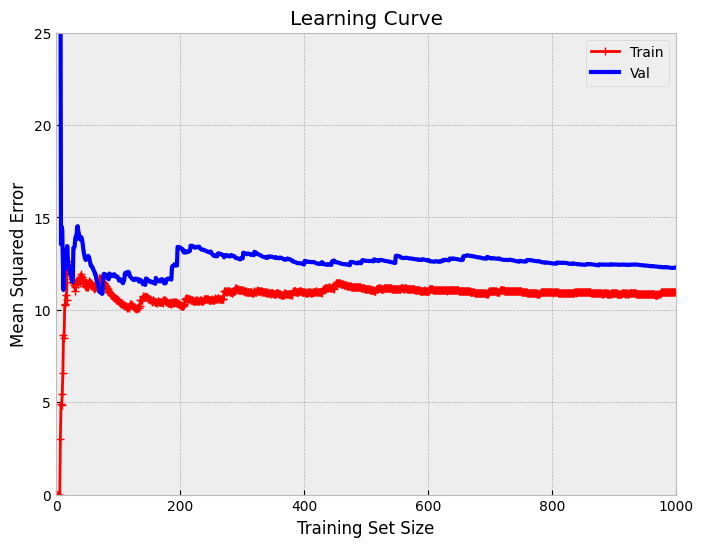

In [44]:
train_errors , val_errors = [] , []
def plot_learning_curve(model):
  for m in range(1 , 1000):
    model.fit(X_train[:m] , y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_test[:m])
    train_errors.append(mean_squared_error(y_train[:m] , y_train_predict))
    val_errors.append(mean_squared_error(y_test[:m] , y_val_predict))

  plt.plot(np.sqrt(train_errors) , "r-+" , linewidth = 2 , label = "Train")
  plt.plot(np.sqrt(val_errors) , "b-" , linewidth = 3 , label = "Val")
  plt.title("Learning Curve")
  plt.xlabel("Training Set Size")
  plt.ylabel("Mean Squared Error")
  plt.xlim([0 , 1000])
  plt.ylim([0 , 25])
  plt.legend()
linreg = LinearRegression()
plot_learning_curve(linreg)

* As we can see , both curves plateaued at `800` in training set size axis.So it means if we increase the training set size more than `800` examples, model's performance will not be improved significantly.So we can reduce the training set size up to `800` examples without decreasing the model's performance.

* Another reason that the training set and validation set could not reach a lower MSE with more examples is that the dataset do not have enough informative features that our learning algorithm can leverage to build more performant model. 

### Building Regression Model

In [45]:
linreg = LinearRegression()
linreg.fit(X_train , y_train)
linreg_prediction = linreg.predict(X_test)

## Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.

- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.

- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

[Source](https://www.udemy.com/course/python-for-data-science-and-machine-learning-bootcamp/)

In [46]:
print("Linear Regression Mean Absolute Error(MAE) : " , round(metrics.mean_absolute_error(y_test , linreg_prediction) , 2))
print("Linear Regression Mean Squared Error(MSE) : " , round(metrics.mean_squared_error(y_test , linreg_prediction) , 2))
print("Linear Regression Root Mean Squared Error(RMSE) : " , round(np.sqrt(metrics.mean_squared_error(y_test , linreg_prediction)) , 2))

Linear Regression Mean Absolute Error(MAE) :  8.52
Linear Regression Mean Squared Error(MSE) :  140.08
Linear Regression Root Mean Squared Error(RMSE) :  11.84


* So we have just implemented a simple `Linear Regression` to predict the calories burned with various parameters.Our RMSE for Linear Regression is about `12` which is acceptable.As just I said it is a simple model.We can reduce this errors with just replacing simple model with more complex model.

* In the next section I will be using the `RandomForestRegressor` algorithm which uses `bagging` method.

### RandomForestRegressor Algorithm
* In this section I will be using the `GridSearchCV` on of the cross-validation methods that we use for selecting `hyperparameters`.

* In this section , I will be using 3 hyperparameters for RandomForestRegressor algorithm which is `n_estimators` , `max_features` and `max_depth`.This will run on 5 splits and the split with highest accuracy will be picked.

**NOTE:** Sometimes running `GridSearchCV` is very time consuming in terms of `computational complexity`.So I have already run the GridSearchCV and put the best parameters into `RandomForestRegressor` directly and then run the model.So I commented out `GridSearchCV` and all of its dependencies.

In [47]:
# forest_reg = RandomForestRegressor()
# param_grid = {'n_estimators' : [10 , 100 , 1000] , 
#               'max_features' : [2 , 2 , 3] , 
#               'max_depth' : [2 , 4 , 6]}

# grid_search = GridSearchCV(forest_reg , param_grid , cv = 5 , scoring = 'neg_mean_squared_error' , n_jobs = -1 , verbose = 3)
# grid_search.fit(X_train , y_train)

In [48]:
# grid_search.best_params_

In [49]:
# grid_search.best_estimator_

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
random_reg = RandomForestRegressor(n_estimators = 1000 , max_features = 3 , max_depth = 6)
random_reg.fit(X_train , y_train)
random_reg_prediction = random_reg.predict(X_test)

* As you can see, we get a slightly better result with `RandomForestRegressor` algorithm.

In [54]:
print("RandomForest Mean Absolute Error(MAE) : " , round(metrics.mean_absolute_error(y_test , random_reg_prediction) , 2))
print("RandomForest Mean Squared Error(MSE) : " , round(metrics.mean_squared_error(y_test , random_reg_prediction) , 2))
print("RandomForest Root Mean Squared Error(RMSE) : " , round(np.sqrt(metrics.mean_squared_error(y_test , random_reg_prediction)) , 2))

RandomForest Mean Absolute Error(MAE) :  5.33
RandomForest Mean Squared Error(MSE) :  69.31
RandomForest Root Mean Squared Error(RMSE) :  8.33


* As we can see the RMSE for `ReandomForestRegressor` is lower than `Linear Regresssion`'s RMSE.It means that we can make better predictions with RandomForestRegressor.

And now let's make a prediction to test model's performance.First we selected an example randomly and passed some numbers (close to feature values of the example) to the model and compared the results.

In [55]:
exercise_train_data.iloc[32]

Age               23
BMI            24.88
Duration        27.0
Heart_Rate     102.0
Body_Temp       40.3
Calories       140.0
Gender_male     True
Name: 5897, dtype: object

In [56]:
X_array = np.array([[24 , 25 , 28 , 100 , 40 , 1]]).reshape(1 , -1)
y_pred = random_reg.predict(X_array)
print("Prediction : " , round(y_pred[0] , 2))

Prediction :  146.16


* As we can see this model did a good job and the predicted value is close to the real value in the dataset.